In [1]:
%load_ext autoreload
%autoreload 2
%cd ..

import numpy as np
import sim2val.control_variates as cv
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

/home/raluo/repos/sim2val


In [2]:
# Load data
real = pd.read_parquet("testdata/nuplan/real.parquet")
sim = pd.read_parquet("testdata/nuplan/paired_sim.parquet")
only_sim = pd.read_parquet("testdata/nuplan/only_sim.parquet")

In [3]:
# Show information about each file
print("="*60)
print("INFORMATION ABOUT EACH FILE")
print("="*60)

print("\n1. real.parquet:")
print(f"   - Rows: {len(real)}")
print(f"   - Columns: {real.columns.tolist()}")

print("\n2. paired_sim.parquet:")
print(f"   - Rows: {len(sim)}")
print(f"   - Columns: {sim.columns.tolist()}")

print("\n3. only_sim.parquet:")
print(f"   - Rows: {len(only_sim)}")
print(f"   - Columns: {only_sim.columns.tolist()}")

# Display first 5 rows of real dataframe as example
print("\n" + "="*50)
print("First 5 rows of `real` dataframe:")
print("="*50)
real.head()

INFORMATION ABOUT EACH FILE

1. real.parquet:
   - Rows: 174540
   - Columns: ['log_name', 'scenario_name', 'scenario_type', 'closed_loop_ade', 'embedding_agent_ego', 'embedding_agent_avg', 'embedding_road_avg']

2. paired_sim.parquet:
   - Rows: 174540
   - Columns: ['log_name', 'scenario_name', 'scenario_type', 'open_loop_ade', 'embedding_agent_ego', 'embedding_agent_avg', 'embedding_road_avg']

3. only_sim.parquet:
   - Rows: 174540
   - Columns: ['log_name', 'scenario_name', 'scenario_type', 'open_loop_ade', 'embedding_agent_ego', 'embedding_agent_avg', 'embedding_road_avg']

First 5 rows of `real` dataframe:


,log_name,scenario_name,scenario_type,closed_loop_ade,embedding_agent_ego,embedding_agent_avg,embedding_road_avg
0,2021.06.09.17.23.18_veh-38_00773_01140,e3451c11c67c5773,stationary,1.973788,"[0.32806596, -1.0012152, -0.5529131, -2.240101...","[0.30201173, -0.15548196, -0.3293944, -1.08141...","[-0.21024618, 1.2106632, 0.19380753, -0.370381..."
1,2021.06.28.15.02.02_veh-38_02398_02848,cd23df3fafa955a8,high_magnitude_speed,8.565867,"[0.049398266, -1.1568279, -0.27508986, -0.9821...","[0.52720153, -0.37657583, -0.17070839, -0.8512...","[-0.22037007, 1.61851, 0.20213248, -0.37811062..."
2,2021.07.16.20.45.29_veh-35_01095_01486,d8891826d3bc53a6,unknown,31.415417,"[0.27029637, -1.3402767, -0.18707198, -1.62526...","[0.27806407, -0.5984355, -0.34917355, -1.32903...","[-0.20652793, 1.2430493, 0.22546518, -0.375199..."
3,2021.06.07.18.53.26_veh-26_00005_00427,0e398575c59051ec,unknown,3.225523,"[0.2798731, -1.5406024, -0.45057607, -2.069411...","[0.6754285, -0.4785704, -0.18736805, -1.097312...","[-0.20688644, 1.4043777, 0.20172518, -0.373582..."
4,2021.06.03.13.55.17_veh-35_00073_00426,9bbdffa85111583a,traversing_traffic_light_intersection,27.751345,"[0.06536361, -1.3246422, -0.344439, -1.2090551...","[0.5175912, -0.115110114, -0.14258435, -0.9387...","[-0.20519334, 1.8549973, 0.18708515, -0.372930..."


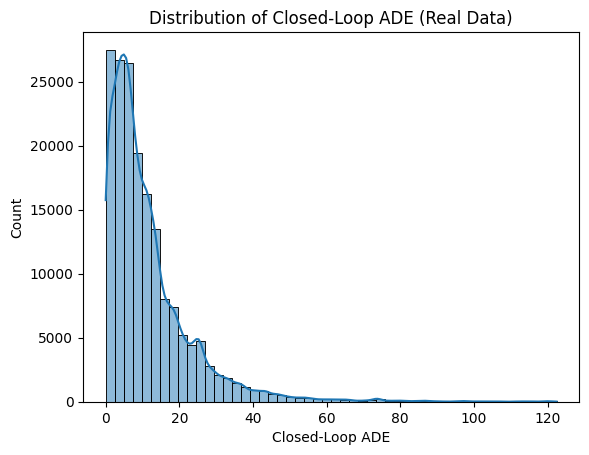

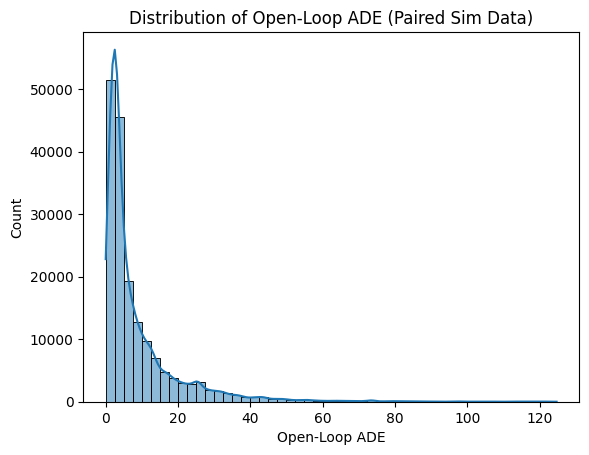

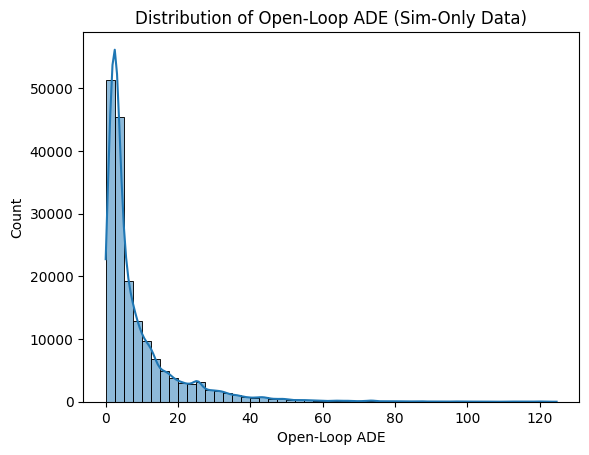

In [4]:
# Plot distribution of closed-loop ADE for real data
sns.histplot(data=real, x="closed_loop_ade", bins=50, kde=True)
plt.title("Distribution of Closed-Loop ADE (Real Data)")
plt.xlabel("Closed-Loop ADE")
plt.ylabel("Count")
plt.show()

# Plot distribution of open-loop ADE for paired sim data
sns.histplot(data=sim, x="open_loop_ade", bins=50, kde=True)
plt.title("Distribution of Open-Loop ADE (Paired Sim Data)")
plt.xlabel("Open-Loop ADE")
plt.ylabel("Count")
plt.show()

# Plot distribution of open-loop ADE for only sim data
sns.histplot(data=only_sim, x="open_loop_ade", bins=50, kde=True)
plt.title("Distribution of Open-Loop ADE (Sim-Only Data)")
plt.xlabel("Open-Loop ADE")
plt.ylabel("Count")
plt.show()

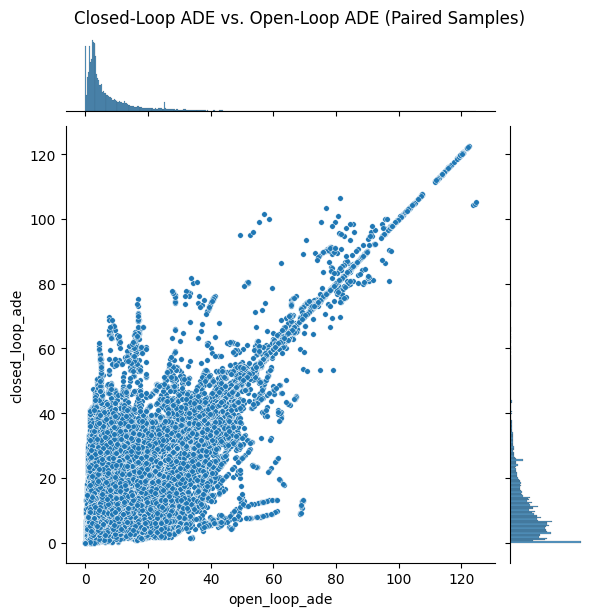

In [5]:
paired = pd.DataFrame({
    "open_loop_ade": sim["open_loop_ade"],
    "closed_loop_ade": real["closed_loop_ade"]
})

sns.jointplot(
    data=paired,
    x="open_loop_ade",
    y="closed_loop_ade",
    kind="scatter",
    s=16, 
    # alpha=0.3 
)

plt.suptitle("Closed-Loop ADE vs. Open-Loop ADE (Paired Samples)", y=1.02)
plt.show()

In [6]:
# Prepare data for control variates estimator

# Extract the metric arrays
f = real['closed_loop_ade'].values  # metric of interest
g = sim['open_loop_ade'].values     # paired metric
g_unpaired = only_sim['open_loop_ade'].values  # additional unpaired metric values

print(f"f (closed_loop_ade): {len(f)} samples")
print(f"g (open_loop_ade paired): {len(g)} samples") 
print(f"g_unpaired (open_loop_ade unpaired): {len(g_unpaired)} samples")
    
# Show basic statistics
print(f"\nBasic statistics:")
print(f"f (closed_loop_ade) - Mean: {np.mean(f):.3f}, Std: {np.std(f):.3f}")
print(f"g (open_loop_ade) - Mean: {np.mean(g):.3f}, Std: {np.std(g):.3f}")
print(f"g_unpaired - Mean: {np.mean(g_unpaired):.3f}, Std: {np.std(g_unpaired):.3f}")
print(f"Correlation between f and g: {np.corrcoef(f, g)[0,1]:.3f}")

f (closed_loop_ade): 174540 samples
g (open_loop_ade paired): 174540 samples
g_unpaired (open_loop_ade unpaired): 174540 samples

Basic statistics:
f (closed_loop_ade) - Mean: 11.571, Std: 11.953
g (open_loop_ade) - Mean: 8.625, Std: 11.590
g_unpaired - Mean: 8.623, Std: 11.541
Correlation between f and g: 0.829


In [7]:
# Apply control variates estimator
result = cv.control_variates_estimator(f, g, g_unpaired)

# Display results
print("CONTROL VARIATES RESULTS:")
print("=" * 50)
print(f"Estimated mean (μ̂_β): {result.mu_hat_beta:.6f}")
print(f"Estimated variance (Var[μ̂_β]): {result.var_mu_hat_beta:.8f}")
print(f"Optimal coefficient (β): {result.beta:.6f}")

# Compare with naive Monte Carlo estimator
naive_mean = np.mean(f)
naive_variance = np.var(f, ddof=1) / len(f)

print("\nMONTE CARLO RESULTS:")
print("=" * 50)
print(f"Monte Carlo mean: {naive_mean:.6f}")
print(f"Monte Carlo variance: {naive_variance:.8f}")

print("\nCOMPARISON:")
print("=" * 50)

# Variance reduction
variance_reduction = (naive_variance - result.var_mu_hat_beta) / naive_variance
print(f"Variance reduction: {variance_reduction*100:.1f}%")

# Confidence intervals using both methods
confidence_level = 0.95

# Control variates confidence interval (using CLT)
cv_ci = cv.confidence_interval_clt(result.mu_hat_beta, result.var_mu_hat_beta, confidence_level)
print(f"Control variates confidence interval (CLT): [{cv_ci[0]:.4f}, {cv_ci[1]:.4f}]")

# Naive Monte Carlo confidence interval (using CLT)
naive_ci = cv.confidence_interval_clt(naive_mean, naive_variance, confidence_level)
print(f"Monte Carlo confidence interval (CLT): [{naive_ci[0]:.4f}, {naive_ci[1]:.4f}]")

# Show confidence interval widths
cv_width = cv_ci[1] - cv_ci[0]
naive_width = naive_ci[1] - naive_ci[0]
print(f"Control variates confidence interval width: {cv_width:.4f}")
print(f"Monte Carlo confidence interval width: {naive_width:.4f}")

CONTROL VARIATES RESULTS:
Estimated mean (μ̂_β): 11.570407
Estimated variance (Var[μ̂_β]): 0.00053604
Optimal coefficient (β): 0.427520

MONTE CARLO RESULTS:
Monte Carlo mean: 11.570896
Monte Carlo variance: 0.00081856

COMPARISON:
Variance reduction: 34.5%
Control variates confidence interval (CLT): [11.5250, 11.6158]
Monte Carlo confidence interval (CLT): [11.5148, 11.6270]
Control variates confidence interval width: 0.0908
Monte Carlo confidence interval width: 0.1122


In [8]:
# Filter data for near_multiple_vehicles scenario_type only
print("Filtering data for 'near_multiple_vehicles' scenario type...")
print("=" * 60)

# Filter for near_multiple_vehicles scenarios
near_multiple_vehicles_mask = real['scenario_type'] == 'near_multiple_vehicles'
real_filtered = real[near_multiple_vehicles_mask].copy()
sim_filtered = sim[near_multiple_vehicles_mask].copy()  # Same mask since they're aligned

# Filter unpaired data 
only_sim_filtered = only_sim[only_sim['scenario_type'] == 'near_multiple_vehicles'].copy()

print(f"Real (near_multiple_vehicles): {len(real_filtered)} samples")
print(f"Sim paired (near_multiple_vehicles): {len(sim_filtered)} samples")
print(f"Only sim (near_multiple_vehicles): {len(only_sim_filtered)} samples")

# Extract filtered metric arrays
f_filtered = real_filtered['closed_loop_ade'].values
g_filtered = sim_filtered['open_loop_ade'].values
g_unpaired_filtered = only_sim_filtered['open_loop_ade'].values

Filtering data for 'near_multiple_vehicles' scenario type...
Real (near_multiple_vehicles): 740 samples
Sim paired (near_multiple_vehicles): 740 samples
Only sim (near_multiple_vehicles): 700 samples


In [9]:
# Apply control variates estimator
result_filtered = cv.control_variates_estimator(f_filtered, g_filtered, g_unpaired_filtered)

# Display results
print("CONTROL VARIATES RESULTS:")
print("=" * 50)
print(f"Estimated mean (μ̂_β): {result_filtered.mu_hat_beta:.6f}")
print(f"Estimated variance (Var[μ̂_β]): {result_filtered.var_mu_hat_beta:.8f}")
print(f"Optimal coefficient (β): {result_filtered.beta:.6f}")

# Compare with naive Monte Carlo estimator
naive_mean = np.mean(f_filtered)
naive_variance = np.var(f_filtered, ddof=1) / len(f_filtered)

print("\nMONTE CARLO RESULTS:")
print("=" * 50)
print(f"Monte Carlo mean: {naive_mean:.6f}")
print(f"Monte Carlo variance: {naive_variance:.8f}")

print("\nCOMPARISON:")
print("=" * 50)

# Variance reduction
variance_reduction = (naive_variance - result_filtered.var_mu_hat_beta) / naive_variance
print(f"Variance reduction: {variance_reduction*100:.1f}%")

# Confidence intervals using both methods
confidence_level = 0.95

# Control variates confidence interval (using CLT)
cv_ci = cv.confidence_interval_clt(result_filtered.mu_hat_beta, result_filtered.var_mu_hat_beta, confidence_level)
print(f"Control variates confidence interval (CLT): [{cv_ci[0]:.4f}, {cv_ci[1]:.4f}]")

# Naive Monte Carlo confidence interval (using CLT)
naive_ci = cv.confidence_interval_clt(naive_mean, naive_variance, confidence_level)
print(f"Naive Monte Carlo confidence interval (CLT): [{naive_ci[0]:.4f}, {naive_ci[1]:.4f}]")

# Show confidence interval widths
cv_width = cv_ci[1] - cv_ci[0]
naive_width = naive_ci[1] - naive_ci[0]
print(f"Control variates confidence interval width: {cv_width:.4f}")
print(f"Monte Carlo confidence interval width: {naive_width:.4f}")

CONTROL VARIATES RESULTS:
Estimated mean (μ̂_β): 13.073751
Estimated variance (Var[μ̂_β]): 0.14261212
Optimal coefficient (β): 0.216051

MONTE CARLO RESULTS:
Monte Carlo mean: 13.108485
Monte Carlo variance: 0.15198247

COMPARISON:
Variance reduction: 6.2%
Control variates confidence interval (CLT): [12.3336, 13.8139]
Naive Monte Carlo confidence interval (CLT): [12.3444, 13.8726]
Control variates confidence interval width: 1.4803
Monte Carlo confidence interval width: 1.5282


### Hmm, here the control variates estimator isn't helping as much as expected. Let's check the correlations...


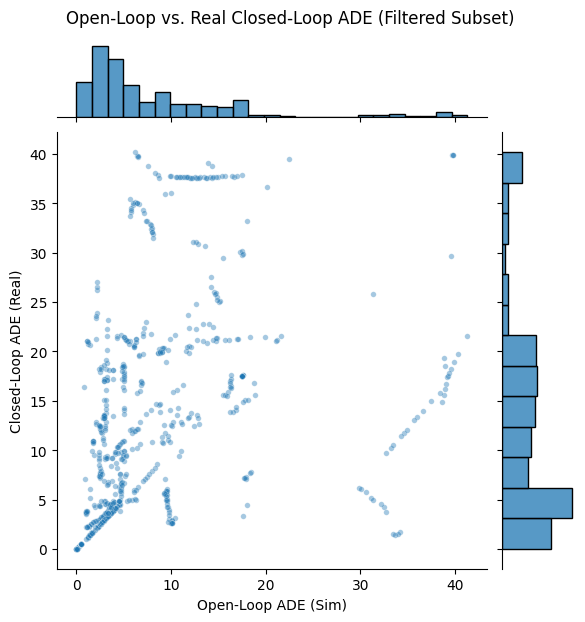

Correlation: 0.353


In [10]:
# Combine into one dataframe for plotting
df_filtered = pd.DataFrame({
    "Open-Loop ADE (Sim)": g_filtered,
    "Closed-Loop ADE (Real)": f_filtered
})

# Scatterplot with marginal histograms
g = sns.jointplot(
    data=df_filtered,
    x="Open-Loop ADE (Sim)",
    y="Closed-Loop ADE (Real)",
    kind="scatter",
    s=16,
    alpha=0.4,
    height=6
)

# Labels and title
g.set_axis_labels("Open-Loop ADE (Sim)", "Closed-Loop ADE (Real)")
plt.suptitle("Open-Loop vs. Real Closed-Loop ADE (Filtered Subset)", y=1.03)
plt.show()

# Check the correlation between f_filtered and g_filtered
print(f"Correlation: {np.corrcoef(f_filtered, g_filtered)[0,1]:.3f}")

### The correlation is low! Let's try to train a model to improve it.

In [11]:
from torch import nn, optim
import torch

class MetricsModel(nn.Module):
    def __init__(self, embedding_dim=128, hidden_dim=256):
        super(MetricsModel, self).__init__()
        self.fc = nn.Sequential(
            nn.Linear(embedding_dim + 1, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, 1)
        )
        
    def forward(self, embedding, open_loop_metric):
        # Concatenate the embedding and open-loop metric before passing to the model
        x = torch.cat([embedding, open_loop_metric], dim=1)
        return self.fc(x)

In [12]:
# Data preprocessing to train MCF

# Exclude the target scenario type (near multiple vehicles) from the paired set
mask = real["scenario_type"] != "near_multiple_vehicles"
real_paired = real[mask].reset_index(drop=True)
sim_paired  = sim[mask].reset_index(drop=True)

# Extract features/target
# Embeddings column is array-like per row; stack into (N, D)
E = np.vstack(real_paired["embedding_agent_avg"].to_numpy())        # (N, D)
g = sim_paired["open_loop_ade"].to_numpy().reshape(-1, 1)           # (N, 1)
y = real_paired["closed_loop_ade"].to_numpy().reshape(-1, 1)        # (N, 1)

N, D = E.shape
print(f"Samples: {N}, Embedding dim: {D}")

Samples: 173800, Embedding dim: 128


In [13]:
# Train MCF

from torch.utils.data import TensorDataset, DataLoader

# Train/val split (80/20, shuffled)
rng = np.random.default_rng(42)
idx = rng.permutation(N)
split = int(0.8 * N)
tr_idx, va_idx = idx[:split], idx[split:]

E_tr, E_va = E[tr_idx], E[va_idx]
g_tr, g_va = g[tr_idx], g[va_idx]
y_tr, y_va = y[tr_idx], y[va_idx]

# Standardize inputs (fit on train only)
E_mean, E_std = E_tr.mean(axis=0, keepdims=True), E_tr.std(axis=0, keepdims=True) + 1e-8
g_mean, g_std = g_tr.mean(axis=0, keepdims=True), g_tr.std(axis=0, keepdims=True) + 1e-8

E_tr_n = (E_tr - E_mean) / E_std
E_va_n = (E_va - E_mean) / E_std
g_tr_n = (g_tr - g_mean) / g_std
g_va_n = (g_va - g_mean) / g_std

# Standardize target 
y_mean, y_std = y_tr.mean(axis=0, keepdims=True), y_tr.std(axis=0, keepdims=True) + 1e-8
y_tr_n = (y_tr - y_mean) / y_std
y_va_n = (y_va - y_mean) / y_std

# Torch tensors + loaders
Xtr_E = torch.from_numpy(E_tr_n).float()
Xva_E = torch.from_numpy(E_va_n).float()
Xtr_g = torch.from_numpy(g_tr_n).float()
Xva_g = torch.from_numpy(g_va_n).float()
Ytr   = torch.from_numpy(y_tr_n).float()
Yva   = torch.from_numpy(y_va_n).float()

train_ds = TensorDataset(Xtr_E, Xtr_g, Ytr)
val_ds   = TensorDataset(Xva_E, Xva_g, Yva)

train_loader = DataLoader(train_ds, batch_size=2048, shuffle=True, drop_last=False)
val_loader   = DataLoader(val_ds, batch_size=4096, shuffle=False, drop_last=False)

# Model / loss / optimizer
model = MetricsModel(embedding_dim=D, hidden_dim=256)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-5)

# Training loop
epochs = 3
best_val = float("inf")
for epoch in range(1, epochs + 1):
    model.train()
    train_loss = 0.0
    for Eb, gb, yb in train_loader:
        optimizer.zero_grad()
        # Ensure gb is shape (B, 1)
        y_pred = model(Eb, gb)
        loss = criterion(y_pred, yb)
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * Eb.size(0)
    train_loss /= len(train_loader.dataset)

    # Validation
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for Eb, gb, yb in val_loader:
            y_pred = model(Eb, gb)
            loss = criterion(y_pred, yb)
            val_loss += loss.item() * Eb.size(0)
    val_loss /= len(val_loader.dataset)

    # Track best
    if val_loss < best_val:
        best_val = val_loss
        best_state = {k: v.cpu().clone() for k, v in model.state_dict().items()}

    print(f"Epoch {epoch:02d} | train MSE (normed): {train_loss:.4f} | val MSE (normed): {val_loss:.4f}")

# # Restore best model
# model.load_state_dict(best_state)

# # Save the best model to file
# model_path = "best_metrics_model.pt"
# torch.save({
#     "model_state_dict": model.state_dict(),
#     "E_mean": E_mean,
#     "E_std": E_std,
#     "g_mean": g_mean,
#     "g_std": g_std,
#     "y_mean": y_mean,
#     "y_std": y_std
# }, model_path)

# print(f"Best model saved to {model_path}")


Epoch 01 | train MSE (normed): 0.4003 | val MSE (normed): 0.2772
Epoch 02 | train MSE (normed): 0.2674 | val MSE (normed): 0.2732
Epoch 03 | train MSE (normed): 0.2574 | val MSE (normed): 0.2599


In [14]:
checkpoint = torch.load("testdata/nuplan/best_model.pt", weights_only=False)

model = MetricsModel(embedding_dim=D, hidden_dim=256)
model.load_state_dict(checkpoint["model_state_dict"])
model.eval()

E_mean = checkpoint["E_mean"]
E_std = checkpoint["E_std"]
g_mean = checkpoint["g_mean"]
g_std = checkpoint["g_std"]
y_mean = checkpoint["y_mean"]
y_std = checkpoint["y_std"]

print("Model and normalization parameters successfully loaded.")

Model and normalization parameters successfully loaded.


In [15]:
# Function to predict in original units
def predict_closed_loop(embeddings, open_loop_vals):
    """
    embeddings: np.ndarray (N, D) in original scale
    open_loop_vals: np.ndarray (N, 1) in original scale
    returns: np.ndarray (N, 1) in original (un-normalized) units
    """
    E_n = (embeddings - E_mean) / E_std
    g_n = (open_loop_vals - g_mean) / g_std
    with torch.no_grad():
        y_hat_n = model(torch.from_numpy(E_n).float(),
                        torch.from_numpy(g_n).float()).numpy()
    # un-standardize target
    return y_hat_n * y_std + y_mean

# Build model inputs for the near multiple vehicles samples (paired + unpaired)

# Paired (has real closed_loop_ade)
E_nm = np.vstack(real_filtered["embedding_agent_avg"].to_numpy())          # (N_paired, D)
g_open_nm = sim_filtered["open_loop_ade"].to_numpy().reshape(-1, 1)        # (N_paired, 1)
f_nm = real_filtered["closed_loop_ade"].to_numpy()                         # (N_paired,)

# Unpaired (only-sim)
E_nm_unp = np.vstack(only_sim_filtered["embedding_agent_avg"].to_numpy())  # (N_unpaired, D)
g_open_nm_unp = only_sim_filtered["open_loop_ade"].to_numpy().reshape(-1, 1)  # (N_unpaired, 1)

# Use the trained model to predict closed_loop_ade; treat predictions as g 
g_pred_nm = predict_closed_loop(E_nm, g_open_nm).reshape(-1)               # (N_paired,)
g_pred_nm_unp = predict_closed_loop(E_nm_unp, g_open_nm_unp).reshape(-1)   # (N_unpaired,)

# Control variates using predicted closed_loop_ade as the proxy g 
result_model_proxy = cv.control_variates_estimator(
    f_nm,                 # real closed_loop_ade (paired)
    g_pred_nm,            # model-predicted closed_loop_ade on paired
    g_pred_nm_unp         # model-predicted closed_loop_ade on unpaired
)

# CLT CI for the model-proxy control variates estimator 
confidence_level = 0.95  # adjust if you like
cv_ci = cv.confidence_interval_clt(
    result_model_proxy.mu_hat_beta,
    result_model_proxy.var_mu_hat_beta,
    confidence_level
)
print(f"Model-proxy CV (CLT {int(confidence_level*100)}% CI): [{cv_ci[0]:.4f}, {cv_ci[1]:.4f}]")

# # (Optional) Inspect variance / beta 
# for name in ["beta_hat", "var_mu_hat_beta", "mu_hat_beta"]:
#     if hasattr(result_model_proxy, name):
#         print(f"{name}: {getattr(result_model_proxy, name)}")

ci_width = cv_ci[1] - cv_ci[0]
print(f"CI width: {ci_width:.4f}")

Model-proxy CV (CLT 95% CI): [12.4534, 13.8435]
CI width: 1.3901


### This looks better! Let's check the correlation again

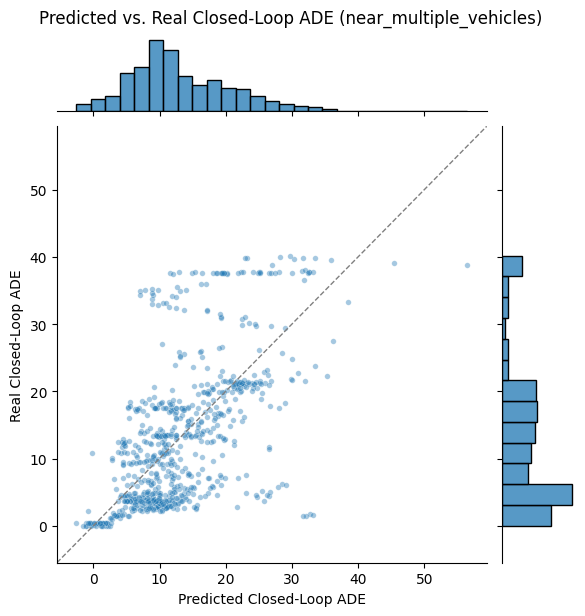

Correlation between predicted and real closed-loop ADE: 0.608


In [16]:
# Combine true and predicted values into one DataFrame
df_pred_vs_real = pd.DataFrame({
    "Predicted Closed-Loop ADE": g_pred_nm,
    "Real Closed-Loop ADE": f_nm,
})

# Scatter + KDE marginals
g = sns.jointplot(
    data=df_pred_vs_real,
    x="Predicted Closed-Loop ADE",
    y="Real Closed-Loop ADE",
    kind="scatter",
    s=16,
    alpha=0.4,
    height=6,
)

# Axis labels and title
g.set_axis_labels("Predicted Closed-Loop ADE", "Real Closed-Loop ADE")
plt.suptitle("Predicted vs. Real Closed-Loop ADE (near_multiple_vehicles)", y=1.02)

# Add a y = x diagonal for reference
ax = g.ax_joint
lims = [
    min(ax.get_xlim()[0], ax.get_ylim()[0]),
    max(ax.get_xlim()[1], ax.get_ylim()[1])
]
ax.plot(lims, lims, '--', color='gray', linewidth=1)
ax.set_xlim(lims)
ax.set_ylim(lims)

plt.show()

corr_np = np.corrcoef(g_pred_nm, f_nm)[0, 1]
print(f"Correlation between predicted and real closed-loop ADE: {corr_np:.3f}")